In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [2]:
from scipy.interpolate import interp2d

In [3]:
import tensorflow as tf
#tf.disable_v2_behavior()

In [4]:
import xarray as xr

In [5]:
diri="Data"
files=glob("/".join([diri,"*"]))

In [6]:
files

['Data\\P-CE-2006-2007-01-01.npy',
 'Data\\P-CE-2017-2017-01-01.npy',
 'Data\\P-CE-2017-2017-01-01_dataSR_CNN.npy',
 'Data\\P-CE-2017-2017-01-01_dataSR_GAN.npy',
 'Data\\wind-20220429-211329',
 'Data\\wind-20220520-112730',
 'Data\\wind-20220520-215250',
 'Data\\wind-20220524-135041',
 'Data\\wind-20220524-135041__wind-20220527-191118__wind-20220528-031534-CE-NodewiseStat.json',
 'Data\\wind-20220524-135041__wind-20220527-191118__wind-20220528-031534-GB-NodewiseStat.json',
 'Data\\wind-20220527-191118',
 'Data\\wind-20220528-031534',
 'Data\\wind-20220528-031534__wind-20220602-122733__wind-20220603-122238-CE-NodewiseStat.json',
 'Data\\wind-20220528-031534__wind-20220602-122733__wind-20220603-122238-GB-NodewiseStat.json',
 'Data\\wind-20220529-120253']

In [7]:
#matplotlib notebook
plt.style.use('seaborn') # pretty matplotlib plots
plt.rcParams['figure.figsize'] = (12, 8)
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20
plt.rcParams['text.usetex'] = False
#plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [8]:
def plot_psd(fft,lab="2dspec"):
    x2=np.abs(fft)**2
    (N,H,W,C)=np.shape(x2)
    k_spec=3000/(W*H)*np.mean(x2[:,1:int(H/2+1),1:int(W/2+1),0],axis=(0,1))
    k=np.arange(1,W/2+1)*1/3000
    plt.figure(figsize=[12,6])
    plt.subplot(1,2,1)
    plt.plot(k,k_spec)#,label=lab)
    plt.plot(k,k**(-5/3)*10**1,"--")#,label="5/3")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel(r"$k_1$ [m$^{-1}$]")
    plt.ylabel(r"PSD [m$^3$/s$^2$]")
    plt.title("u component")
    #plt.legend()

    k_spec=3000/(W*H)*np.mean(x2[:,1:int(H/2+1),1:int(W/2+1),1],axis=(0,2))
    k=np.arange(1,H/2+1)*1/3000
    plt.subplot(1,2,2)
    plt.plot(k,k_spec,label=lab)
    plt.plot(k,k**(-5/3)*10**1*0.2,"--",label="5/3")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel(r"$k_2$ [m$^{-1}$]")
    plt.title("v component")
    plt.legend()

In [9]:
def plot_uv_psds(files,labs):
    u_spec={}
    v_spec={}
    for i,file in enumerate(files):
        data=np.load(file)
        fft=np.fft.fft2(data,axes=(1,2))
        x2=np.abs(fft)**2
        (N,H,W,C)=np.shape(x2)
        u_spec[labs[i]+"_spec"]=3000/(W*H)*np.mean(x2[:,1:int(H/2+1),1:int(W/2+1),0],axis=(0,1))
        u_spec[labs[i]+"_k"]=2*np.pi*np.arange(1,W/2+1)*1/3000 
        v_spec[labs[i]+"_spec"]=3000/(W*H)*np.mean(x2[:,1:int(H/2+1),1:int(W/2+1),1],axis=(0,2))
        v_spec[labs[i]+"_k"]=2*np.pi*np.arange(1,H/2+1)*1/3000
        

    plt.figure(figsize=[12,6])
    plt.subplot(1,2,1)
    for lab in labs:
        k=u_spec[lab+"_k"]
        spec=u_spec[lab+"_spec"]
        plt.plot(k,spec)#,label=lab)
    plt.plot(k,k**(-5/3)*10**1,"--")#,label="5/3")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel(r"$k_1$ [m$^{-1}$]")
    plt.ylabel(r"PSD [m$^3$/s$^2$]")
    plt.title("u component")
    #plt.legend()

    plt.subplot(1,2,2)
    for lab in labs:
        k=v_spec[lab+"_k"]
        spec=v_spec[lab+"_spec"]
        plt.plot(k,spec,label=lab)
    plt.plot(k,k**(-5/3)*10**1*0.5,"--",label="5/3")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel(r"$k_2$ [m$^{-1}$]")
    plt.title("v component")
    plt.legend()

In [10]:
def get_grid(ncfile='//smb.uni-oldenburg.de/hpc_data/thesis/data/ncfiles\\P-CE-2017-2017-01-01.nc',dom="CE"):
    ds=xr.open_dataset(ncfile)
    if dom=="CE":
        ds=ds.isel(south_north=slice(2,412))
    else:
        ds=ds.isel(west_east=slice(3,393))
    ds=ds.isel(height=2,time=0)
    LR=ds.WS.coarsen(south_north=10,west_east=10).mean()
    grid={}#init
    grid["sn_lr"]=LR.south_north.values
    grid["we_lr"]=LR.west_east.values
    grid["sn"]=ds.south_north.values
    grid["we"]=ds.west_east.values
    ds.close()
    
    return grid



In [11]:
grid_CE=get_grid()

In [12]:
grid_UK=get_grid('//smb.uni-oldenburg.de/hpc_data/thesis/data/ncfiles\\P-GB-2018-2018-12-17.nc',dom="GB")

In [13]:
def get_bicubic_interp_SR(LR_val,grid):


    SR_all=None
    for i in range(np.shape(LR_val)[0]):
        fu=interp2d(grid["we_lr"],grid["sn_lr"],LR_val[i,:,:,0],kind="cubic")
        fv=interp2d(grid["we_lr"],grid["sn_lr"],LR_val[i,:,:,1],kind="cubic")
        zu = fu(grid["we"], grid["sn"])
        zv = fv(grid["we"], grid["sn"])

        SR=np.stack([zu,zv],axis=-1)
        SR=SR[np.newaxis,...]
        if SR_all is None:
            SR_all=SR
        else:
            SR_all=np.concatenate([SR_all,SR],axis=0)
    return SR_all


In [14]:
def downscale_image(x, K):
    tf.reset_default_graph()

    if x.ndim == 3:
        x = x.reshape((1, x.shape[0], x.shape[1], x.shape[2]))

    x_in = tf.placeholder(tf.float64, [None, x.shape[1], x.shape[2], x.shape[3]])
    weight = tf.constant(1.0/K**2, shape=[K, K, x.shape[3], 1], dtype=tf.float64)
    p_filt=tf.eye(2,batch_shape=[1,1],  dtype=tf.float64)
    downscaled = tf.nn.separable_conv2d(x_in,depthwise_filter=weight,pointwise_filter=p_filt, strides=[1, K, K, 1], padding='SAME')
    with tf.Session() as sess:
        ds_out = sess.run(downscaled, feed_dict={x_in: x})
    return ds_out


In [51]:
def get_plot_data(p0="//smb.uni-oldenburg.de/hpc_data/thesis/data",file="P-CE-2006-2007-01-01_dataSR.npy",idx=-1,models=None,labs=None,dom="CE",dx=3000):
    spec={}
    target_file="/".join([p0,"test",dom,"final",file[10:14],file.replace("_dataSR","")])
    target=np.load(target_file)
    LR=downscale_image(target,10)
    (N,H0,W0,C)=np.shape(target)
    for i,model in enumerate(models):
        if model =="":
            data=target
        elif model=="Bicubic":
            if dom=="CE":
                data=get_bicubic_interp_SR(LR,grid_CE)
            elif dom=="GB":
                data=get_bicubic_interp_SR(LR,grid_UK)
                print("baseline done")
        elif model=="LR":
            data=LR
        else:
            data=np.load("/".join([p0,"out",model,file]))
            
        norm=np.linalg.norm(data,axis=-1)
        fft=np.fft.fft2(norm,axes=(1,2))
        x2=np.abs(fft)**2
        (N,H,W)=np.shape(x2)
        
        # create array of radii
        #image=np.mean(x2[:,1:int(H/2+1),1:int(W/2+1)],axis=0)
        #image=x2[idx,1:int(H/2+1),1:int(W/2+1)]
        
        spec[labs[i]+"_spec"]=x2[idx,1:int(H/2+1),1:int(W/2+1)]
    return spec

def get_radial_avg(image,dx=3000,num2=50):
    H,W=image.shape
    W*=2
    H*=2
    x,y = np.meshgrid(np.arange(1,W/2+1),np.arange(1,H/2+1))
    R = np.sqrt(x**2+y**2)

    f= lambda i : image[(R >= r[i-1]) & (R < r[i+1])].mean()
    f2= lambda i : np.sum(image[(R >= r[i-1]) & (R < r[i+1])].shape)

    r = np.logspace(0,np.log10(np.max(R)),num2)

    mean=np.vectorize(f)(np.arange(0,num2-1))
    n=np.vectorize(f2)(np.arange(0,num2-1))
    cond=n>1
    mean=mean[np.where(cond)]

    r=r[:-1]+np.diff(r)/2
    r=r[np.where(cond)]

    scaling=dx/(W*H)/2/np.pi
    
#     spec[labs[i]+"_k"]=2*np.pi*(r)/dx
#     spec[labs[i]+"_spec"]=mean*scaling
#     spec[labs[i]+"_r"]=r
#     spec[labs[i]+"_n"]=n
    mean*=scaling
    k=2*np.pi/dx/np.flip(r)
    return mean,k,r,n
        
def plot_psds(spec,savefig=0,gt_scaling=10**4*0.2,xlim=None,ylim=None,num=50,size=[12,6]):        

    plt.figure(figsize=size)
    for lab in labs:
        plot_spec,k,r,n=get_radial_avg(spec[lab+"_spec"],num2=num)
        #k=np.append(k[1:],2*np.pi/3000)
        if lab=="Target":
            plt.plot(k,plot_spec,"r",label=lab)
        else:
            plt.plot(k,plot_spec,label=lab)
    plt.plot(k,k**(-5/3)*gt_scaling,"--k",label=r"$-5/3$")
    #plt.plot(k,k**(-5/3)*10**10*0.2,"--k",label="5/3")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel(r"$k$ [m$^{-1}$]")
    plt.ylabel(r"PSD [m$^3$/s$^2$]")
    plt.legend(frameon=True)
    if ylim is not None:
        plt.ylim(ylim)
    else:
        plt.ylim(1e1)
    
    if xlim is not None:
        plt.xlim(xlim)
    
    if savefig:
        plt.savefig('spec.png', dpi=200, bbox_inches='tight')
    return plot_spec,k

In [28]:
file="P-CE-2006-2007-01-01_dataSR.npy"
models=['wind-20220524-135041',"wind-20220527-191118",'wind-20220528-031534',"wind-20220602-122733","wind-20220603-122238","Bicubic",""]
labs=["CNN1","CNN1 - HR static","CNN2 - HR static","WGAN","WGAN - HR static","Bicubic","Target"]

In [29]:
plot_spec=get_plot_data(file=file,models=models,labs=labs)

C:\Users\Notandi\Anaconda3\envs\tf_env\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice.
C:\Users\Notandi\Anaconda3\envs\tf_env\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Notandi\Anaconda3\envs\tf_env\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice.
C:\Users\Notandi\Anaconda3\envs\tf_env\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Notandi\Anaconda3\envs\tf_env\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice.
C:\Users\Notandi\Anaconda3\envs\tf_env\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Notandi\Anaconda3\envs\tf_env\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning

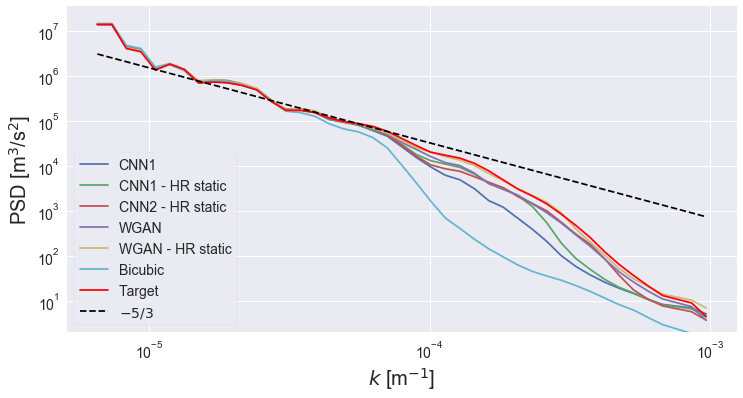

In [52]:
spec,k=plot_psds(plot_spec,savefig=1,num=50,size=[12,6],gt_scaling=7e-3,ylim=2e0)#,xlim=(plot_spec["Target_k"][0],plot_spec["Target_k"][-2]))

In [53]:
spec

array([1.3845899e+07, 1.3845899e+07, 4.0436442e+06, 3.4294778e+06,
       1.3399618e+06, 1.8256735e+06, 1.3958559e+06, 6.9390750e+05,
       7.2912344e+05, 6.9906631e+05, 6.1082238e+05, 4.8671494e+05,
       2.6923419e+05, 1.7257389e+05, 1.7047869e+05, 1.5331647e+05,
       1.1511645e+05, 9.6764922e+04, 8.7276156e+04, 7.5579773e+04,
       5.8695641e+04, 4.0708676e+04, 2.8359910e+04, 2.0164738e+04,
       1.7272039e+04, 1.4911904e+04, 1.1441818e+04, 7.7695591e+03,
       4.9044580e+03, 3.0745730e+03, 2.1503665e+03, 1.4353013e+03,
       8.5080780e+02, 4.8037646e+02, 2.5659839e+02, 1.2441116e+02,
       6.4745682e+01, 3.6725647e+01, 2.1578379e+01, 1.3206820e+01,
       9.0271082e+00, 4.5392880e+00], dtype=float32)

In [54]:
k

array([6.54489688e-06, 7.37122539e-06, 8.30188233e-06, 9.35003973e-06,
       1.05305327e-05, 1.18600692e-05, 1.33574668e-05, 1.50439190e-05,
       1.69432949e-05, 1.90824772e-05, 2.14917429e-05, 2.42051913e-05,
       2.72612272e-05, 3.07031040e-05, 3.45795364e-05, 3.89453893e-05,
       4.38624547e-05, 4.94003261e-05, 5.56373835e-05, 6.26619031e-05,
       7.05733062e-05, 7.94835666e-05, 8.95187954e-05, 1.00821026e-04,
       1.13550224e-04, 1.27886552e-04, 1.44032918e-04, 1.62217851e-04,
       1.82698729e-04, 2.05765428e-04, 2.31744423e-04, 2.61003406e-04,
       2.93956493e-04, 3.31070085e-04, 3.72869468e-04, 4.19946248e-04,
       4.72966726e-04, 5.32681325e-04, 5.99935213e-04, 6.75680268e-04,
       8.57067451e-04, 9.65276837e-04])

In [32]:
file="P-GB-2006-2007-01-01_dataSR.npy"
plot_spec2=get_plot_data(file=file,models=models,labs=labs,dom="GB")

ValueError: cannot reshape array of size 0 into shape (8,540,390,2)

C:\Users\Notandi\Anaconda3\envs\tf_env\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice.
C:\Users\Notandi\Anaconda3\envs\tf_env\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Notandi\Anaconda3\envs\tf_env\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice.
C:\Users\Notandi\Anaconda3\envs\tf_env\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Notandi\Anaconda3\envs\tf_env\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice.
C:\Users\Notandi\Anaconda3\envs\tf_env\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Notandi\Anaconda3\envs\tf_env\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning

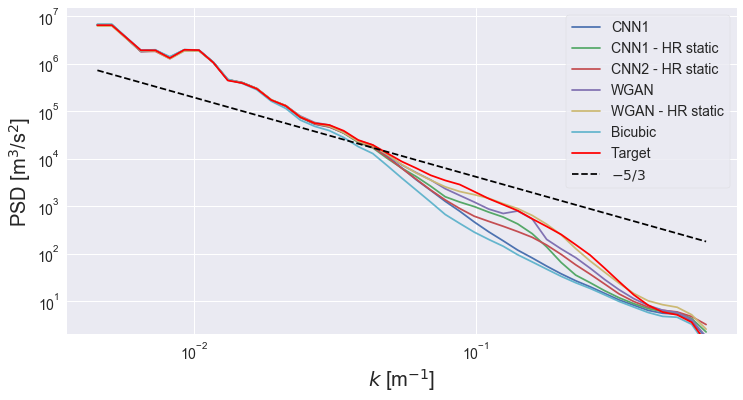

In [31]:
plot_psds(plot_spec2,savefig=0,gt_scaling=0.9*10**2,num=50,ylim=2)#,xlim=(plot_spec2["Target_k"][3],plot_spec2["Target_k"][-3]),ylim=(1e1,5e6))

C:\Users\Notandi\Anaconda3\envs\tf_env\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice.
C:\Users\Notandi\Anaconda3\envs\tf_env\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Notandi\Anaconda3\envs\tf_env\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice.
C:\Users\Notandi\Anaconda3\envs\tf_env\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Notandi\Anaconda3\envs\tf_env\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice.
C:\Users\Notandi\Anaconda3\envs\tf_env\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Notandi\Anaconda3\envs\tf_env\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning

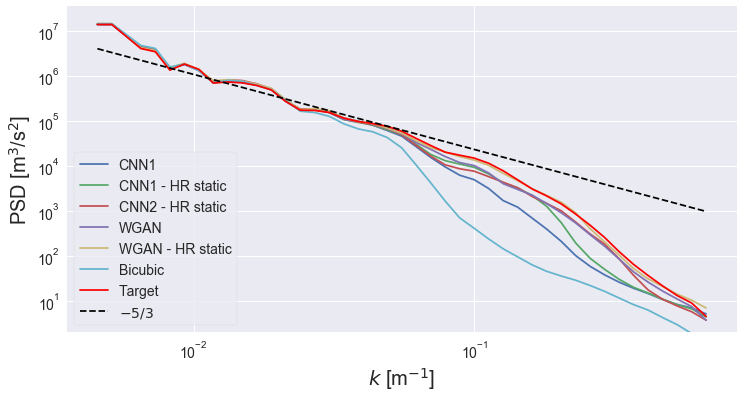

In [42]:
plot_psds(plot_spec,savefig=1,num=50,size=[12,6],gt_scaling=5*10**2,ylim=2e0)#,xlim=(plot_spec["Target_k"][0],plot_spec["Target_k"][-2]))

In [ ]:
file="P-GB-2007-2007-06-01_dataSR.npy"
plot_psds(plot_spec,savefig=1,num=50,size=[12,6],gt_scaling=5*10**2,ylim=2e0)#,xlim=(plot_spec["Target_k"][0],plot_spec["Target_k"][-2]))

C:\Users\Notandi\Anaconda3\envs\tf_env\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice.


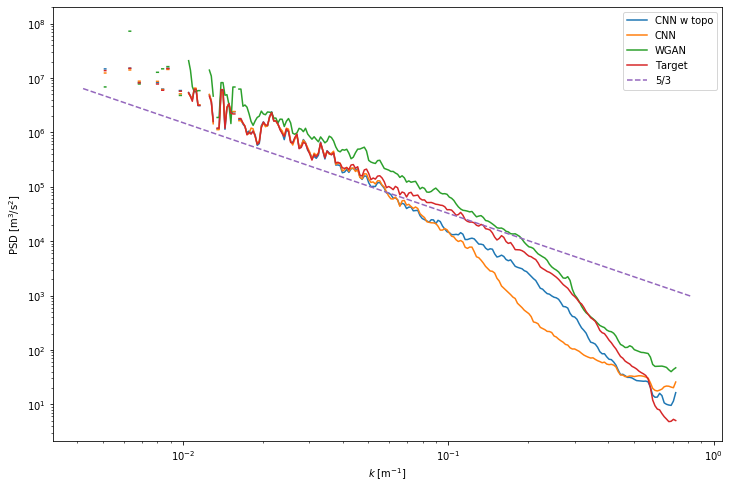

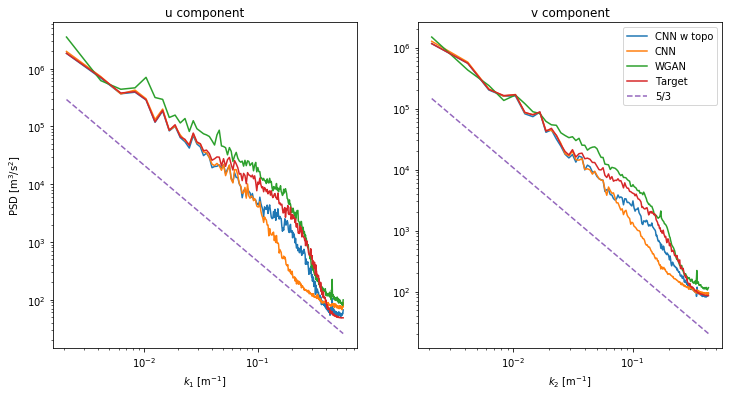

In [299]:
#files=['Data\\wind-20220429-211329\\P-CE-2017-2017-01-01_dataSR.npy','Data\\wind-20220520-215250\\P-CE-2017-2017-01-01_dataSR.npy','Data\\wind-20220520-112730\\P-CE-2017-2017-01-01_dataSR.npy','Data\\P-CE-2017-2017-01-01.npy']
#labs=["CNN2 w topo","CNN1 w topo","CNN1","Target"]
file=
models=['Data\\wind-20220429-211329\\P-CE-2017-2017-01-01_dataSR.npy','Data\\wind-20220520-112730\\P-CE-2017-2017-01-01_dataSR.npy','Data\\wind-20220529-120253\\P-CE-2006-2007-01-01_dataSR.npy','Data\\P-CE-2017-2017-01-01.npy']
labs=["CNN w topo","CNN","WGAN","Target"]
plot_psds(files,labs)
plot_uv_psds(files,labs)

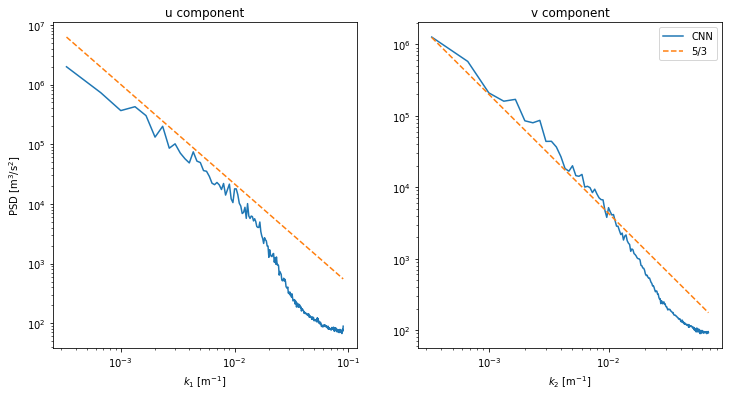

In [26]:
file='Data\\wind-20220520-112730\\P-CE-2017-2017-01-01_dataSR.npy'
data=np.load(file)
fft=np.fft.fft2(data,axes=(1,2))
plot_psd(fft,"CNN")

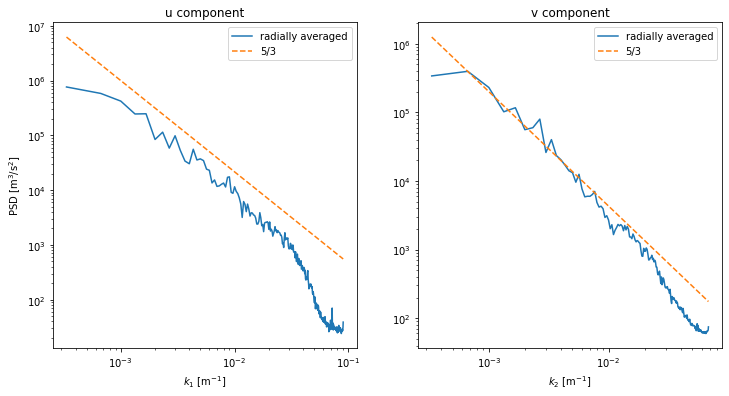

In [121]:
plot_psd(spec_den)

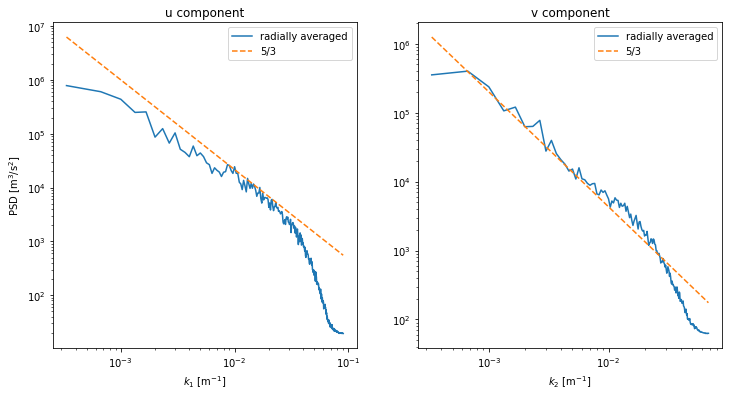

In [111]:
plot_psd(spec_den)

# NOTES
The PSD of a time series signal is:
$$S(f)=1/(Nf_s)|X|^2$$
where N is the number of samples, f_s is the sampling freq and X are the (positive freq) fourier amplitudes from the fft function.

I am plotting 
$$S(k_1)=|X|^2$$
averaged over $k_2$ (and vice versa).
The unit of k should be 1/m. I achieve this by dividing the index by 3000m. Bigger wavenumbers should correspond to smaller scales. The smallest scale is 3km. 

The unit of the PSD in k-space is m^3/s^2. The unit of the spectral amplitudes is m^2/s^2. I should mulitply the spec amplitudes by dx=3000 m to get m^3/s^2. However, I also need to normalize the spectrum to get a spectral density.
This is non-normalized spectrum.




###  Ásta

In [134]:
#%%
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
# %%
diri="Data"
files=glob("/".join([diri,"*"]))
data=np.load(files[0])
(N,H,W,C)=np.shape(data) # (Time, Height, Width, [u,v])
print(N,H,W,C)


8 410 540 2


C:\Users\Notandi\Anaconda3\envs\tf_env\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Notandi\Anaconda3\envs\tf_env\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


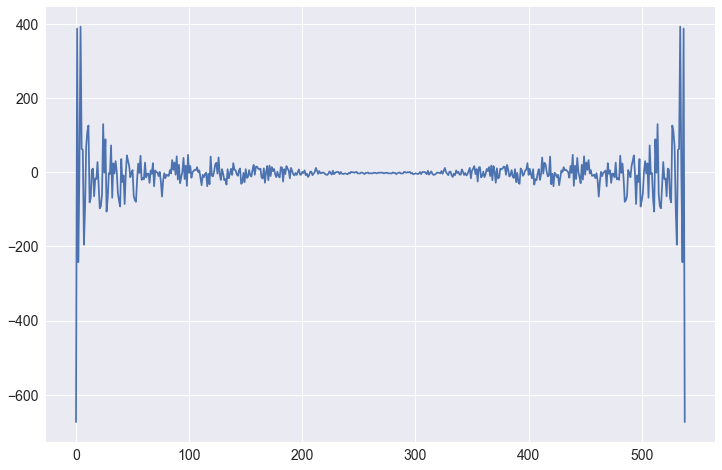

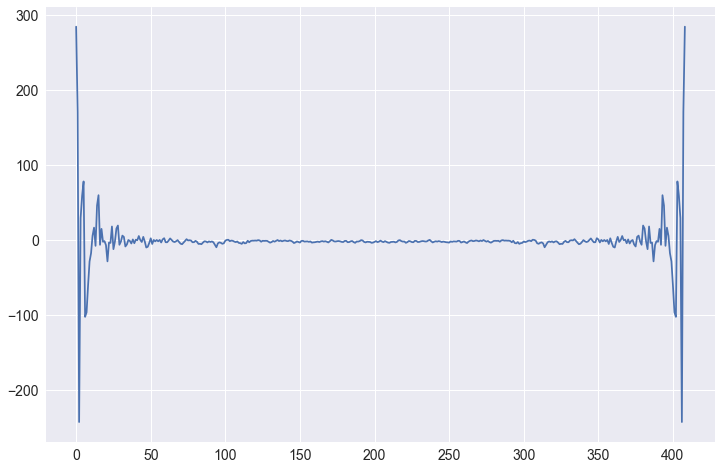

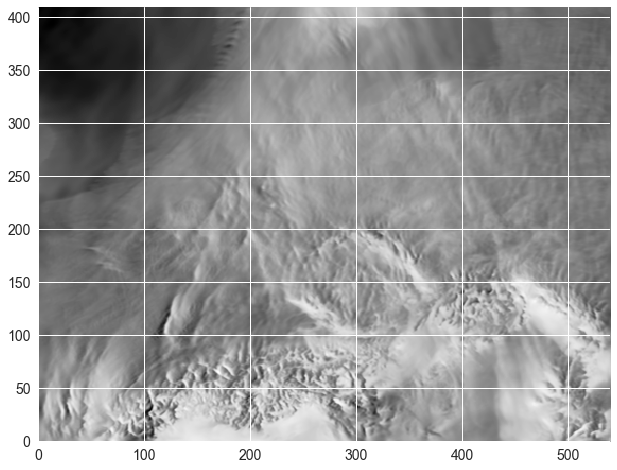

In [135]:
# %%
fft=np.fft.fft2(data,axes=(1,2)) #axes used to perform fft over H and W dimensions

'''
The symmetry in 2D Fourier space follows: x(k1,k2) = x(-k1,-k2). 
Therfore choosing k2=N2/2 or k1=N1/2 will result in a symmetric 1D plot
'''
plt.figure()
plt.plot(fft[0,int(H/2),1:,0])

plt.figure()
plt.plot(fft[0,1:,int(W/2),0])

plt.figure()
plt.imshow(data[0,:,:,0], origin='lower')


'\nNote that the spectra are not radially averaged, but averaged over the latitude (u-spectra)\nand longitude (v-spectra).\nYou can also choose to plot the spectra of wsp (sqrt(u**2 + v**2)), instead and do a radial average.\n'

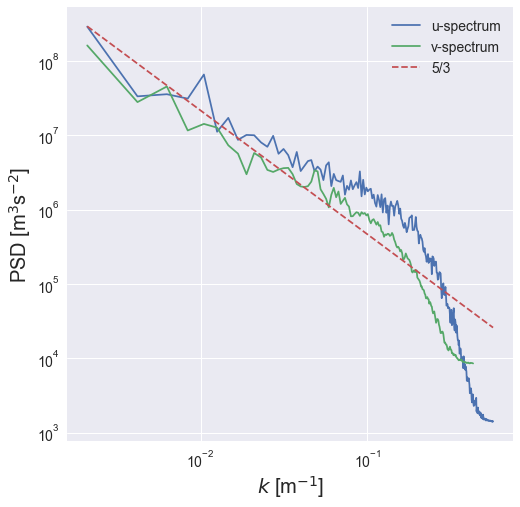

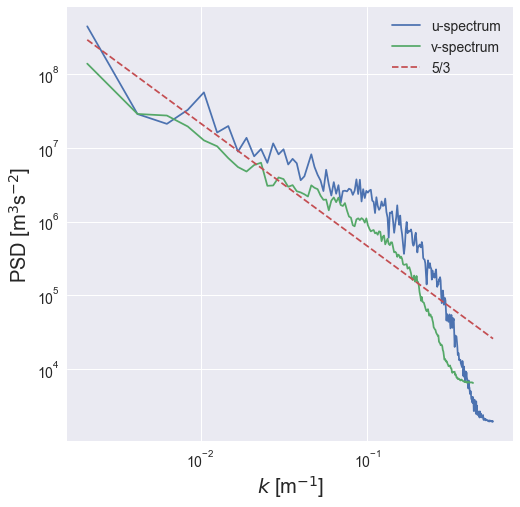

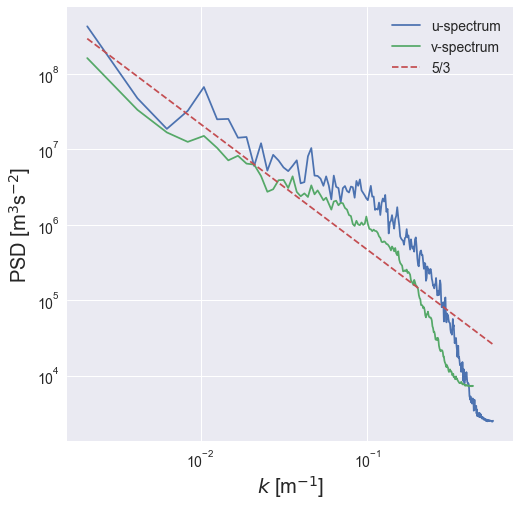

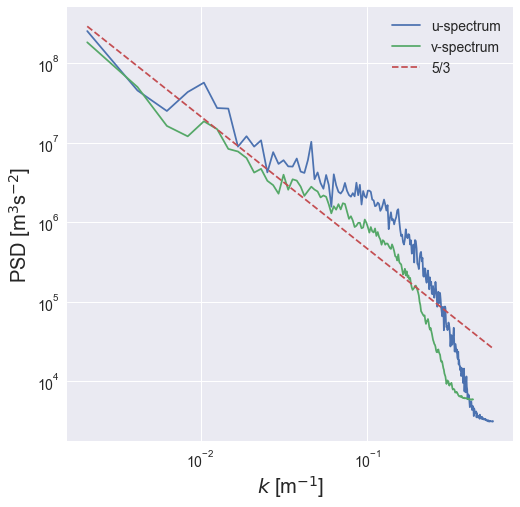

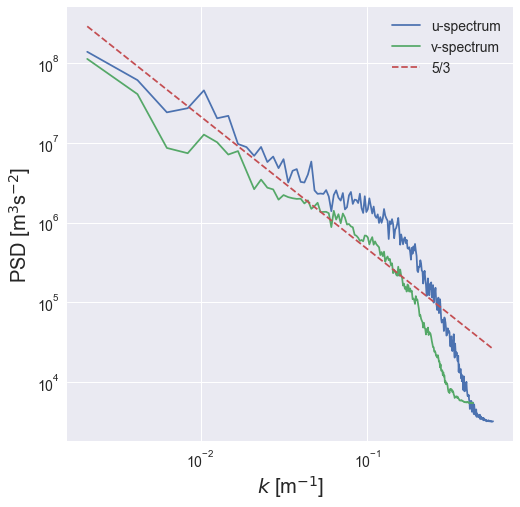

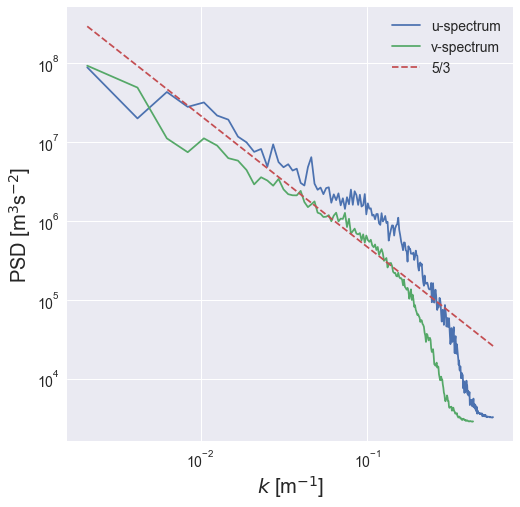

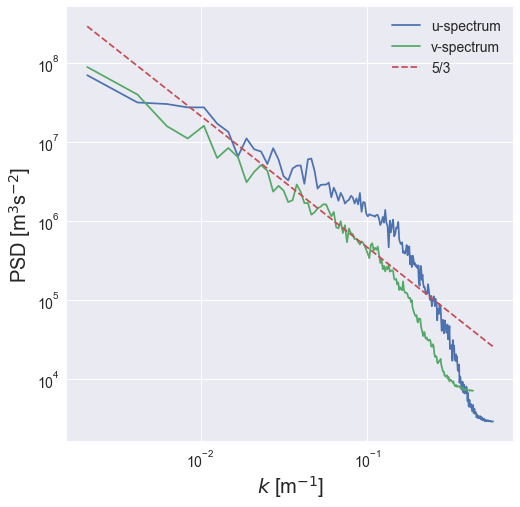

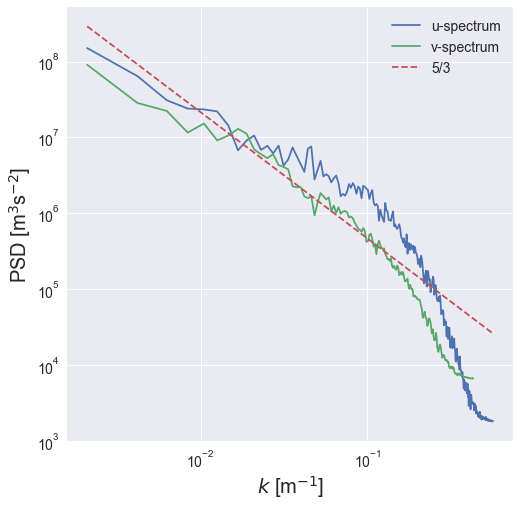

In [138]:

# %%
dx = 3000
u_spec = dx/np.pi/2/W*np.abs(fft[:,:,:,0])**2
v_spec = dx/np.pi/2/H*np.abs(fft[:,:,:,1])**2
k1 = np.arange(W)*2*np.pi/dx
k2 = np.arange(H)*2*np.pi/dx
'''
f*S(f) = k*S(k) =>  S(k) = dx/(N*2*pi)*|x|**2
Why? Try deriving... :-)
'''

# %%
for i in range(N):
    plt.figure(figsize=[8,8])
    plt.loglog(k1[1:int(W/2)+1], u_spec[i,1:int(H/2)+1,1:int(W/2)+1].mean(axis=0),label='u-spectrum')
    plt.loglog(k2[1:int(H/2)+1], v_spec[i,1:int(H/2)+1,1:int(W/2)+1].mean(axis=1),label='v-spectrum')
    plt.loglog(k1[1:int(W/2)+1],k1[1:int(W/2)+1]**(-5/3)*10**4,"--",label="5/3")
    plt.legend()
    plt.xlabel(r"$k$ [m$^{-1}$]")
    plt.ylabel(r"PSD [m$^{3}$s$^{-2}$]")

'''
Note that the spectra are not radially averaged, but averaged over the latitude (u-spectra)
and longitude (v-spectra).
You can also choose to plot the spectra of wsp (sqrt(u**2 + v**2)), instead and do a radial average.
'''
# %%


Text(0, 0.5, 'PSD [m$^{3}$s$^{-2}$]')

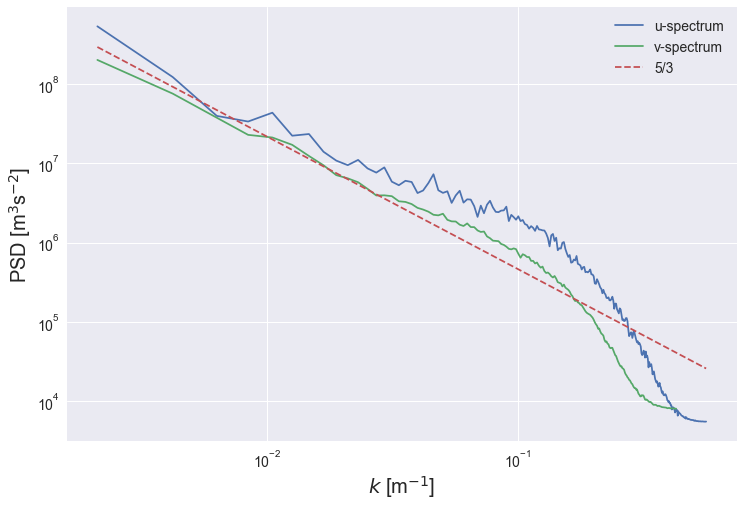

In [139]:
plt.figure()
plt.loglog(k1[1:int(W/2)+1], u_spec[:,:,1:int(W/2)+1].mean(axis=(0,1)),label='u-spectrum')
plt.loglog(k2[1:int(H/2)+1], v_spec[:,1:int(H/2)+1,:].mean(axis=(0,2)),label='v-spectrum')
plt.loglog(k1[1:int(W/2)+1],k1[1:int(W/2)+1]**(-5/3)*10**4,"--",label="5/3")
plt.legend()
plt.xlabel(r"$k$ [m$^{-1}$]")
plt.ylabel(r"PSD [m$^{3}$s$^{-2}$]")